In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [7]:
linear_model = nn.Linear(1, 1)
linear_model(t_un_val)

tensor([[-0.0571],
        [-0.0494]], grad_fn=<AddmmBackward>)

In [8]:
linear_model.weight

Parameter containing:
tensor([[0.0426]], requires_grad=True)

In [9]:
linear_model.bias

Parameter containing:
tensor([-0.2015], requires_grad=True)

In [10]:
linear_model(torch.ones(1))

tensor([-0.1589], grad_fn=<AddBackward0>)

In [11]:
torch.ones(1)

tensor([1.])

In [12]:
model = nn.Linear(1, 1)

optimizer = optim.SGD(model.parameters(), lr=1e-2)

In [14]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0783]], requires_grad=True), Parameter containing:
 tensor([-0.5526], requires_grad=True)]

In [16]:
criterion = nn.MSELoss()

In [27]:
def training_loop(n_epochs, optimizer, model, loss_fn, x_train, x_val, y_train, y_val):
    for epoch in range(1, n_epochs+1):
        t_p_train = model(x_train)

        train_loss = loss_fn(t_p_train, y_train)

        t_p_val = model(x_val)

        val_loss = loss_fn(t_p_val, y_val)

        optimizer.zero_grad()

        train_loss.backward()

        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
            f" Validation loss {val_loss.item():.4f}")


In [28]:
training_loop(n_epochs=3000, 
              optimizer = optimizer, 
              model = model, 
              loss_fn = criterion, 
              x_train = t_un_train,
              x_val = t_un_val,
              y_train = t_c_train,
              y_val = t_c_val)

print()
print(model.weight)
print(model.bias)

Epoch 1, Training loss 255.5847, Validation loss 8.1752
Epoch 1000, Training loss 4.2677, Validation loss 4.2885
Epoch 2000, Training loss 2.9433, Validation loss 3.0031
Epoch 3000, Training loss 2.8598, Validation loss 3.2912

Parameter containing:
tensor([[5.4088]], requires_grad=True)
Parameter containing:
tensor([-17.5969], requires_grad=True)


In [46]:
seq_model = nn.Sequential(
            nn.Linear(1, 13),
            nn.Tanh(),
            nn.Linear(13, 1)
)

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [30]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [31]:
for name, params in seq_model.named_parameters():
    print(name, params.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [47]:
optimizer = optim.SGD(seq_model.parameters(), lr =1e-3)

training_loop(n_epochs=5000,
              optimizer=optimizer,
              model = seq_model,
              loss_fn = nn.MSELoss(),
              x_train = t_un_train,
              x_val = t_un_val,
              y_train = t_c_train,
              y_val = t_c_val)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model[0].weight.grad)

Epoch 1, Training loss 249.1352, Validation loss 8.1370
Epoch 1000, Training loss 10.6331, Validation loss 3.0541
Epoch 2000, Training loss 4.2983, Validation loss 3.7969
Epoch 3000, Training loss 2.2542, Validation loss 4.1519
Epoch 4000, Training loss 1.6749, Validation loss 4.3804
Epoch 5000, Training loss 1.5615, Validation loss 4.5498
output tensor([[-0.0484],
        [ 0.6573]], grad_fn=<AddmmBackward>)
answer tensor([[3.0000],
        [0.5000]])
hidden tensor([[-1.9429e-01],
        [ 2.0197e-01],
        [ 1.4114e+00],
        [ 9.2934e-04],
        [ 1.9536e+00],
        [ 1.0168e-01],
        [ 2.0294e+00],
        [ 1.8940e+00],
        [-1.8947e-03],
        [ 6.9973e-01],
        [ 6.1436e-04],
        [ 3.6207e-01],
        [ 1.9357e+00]])


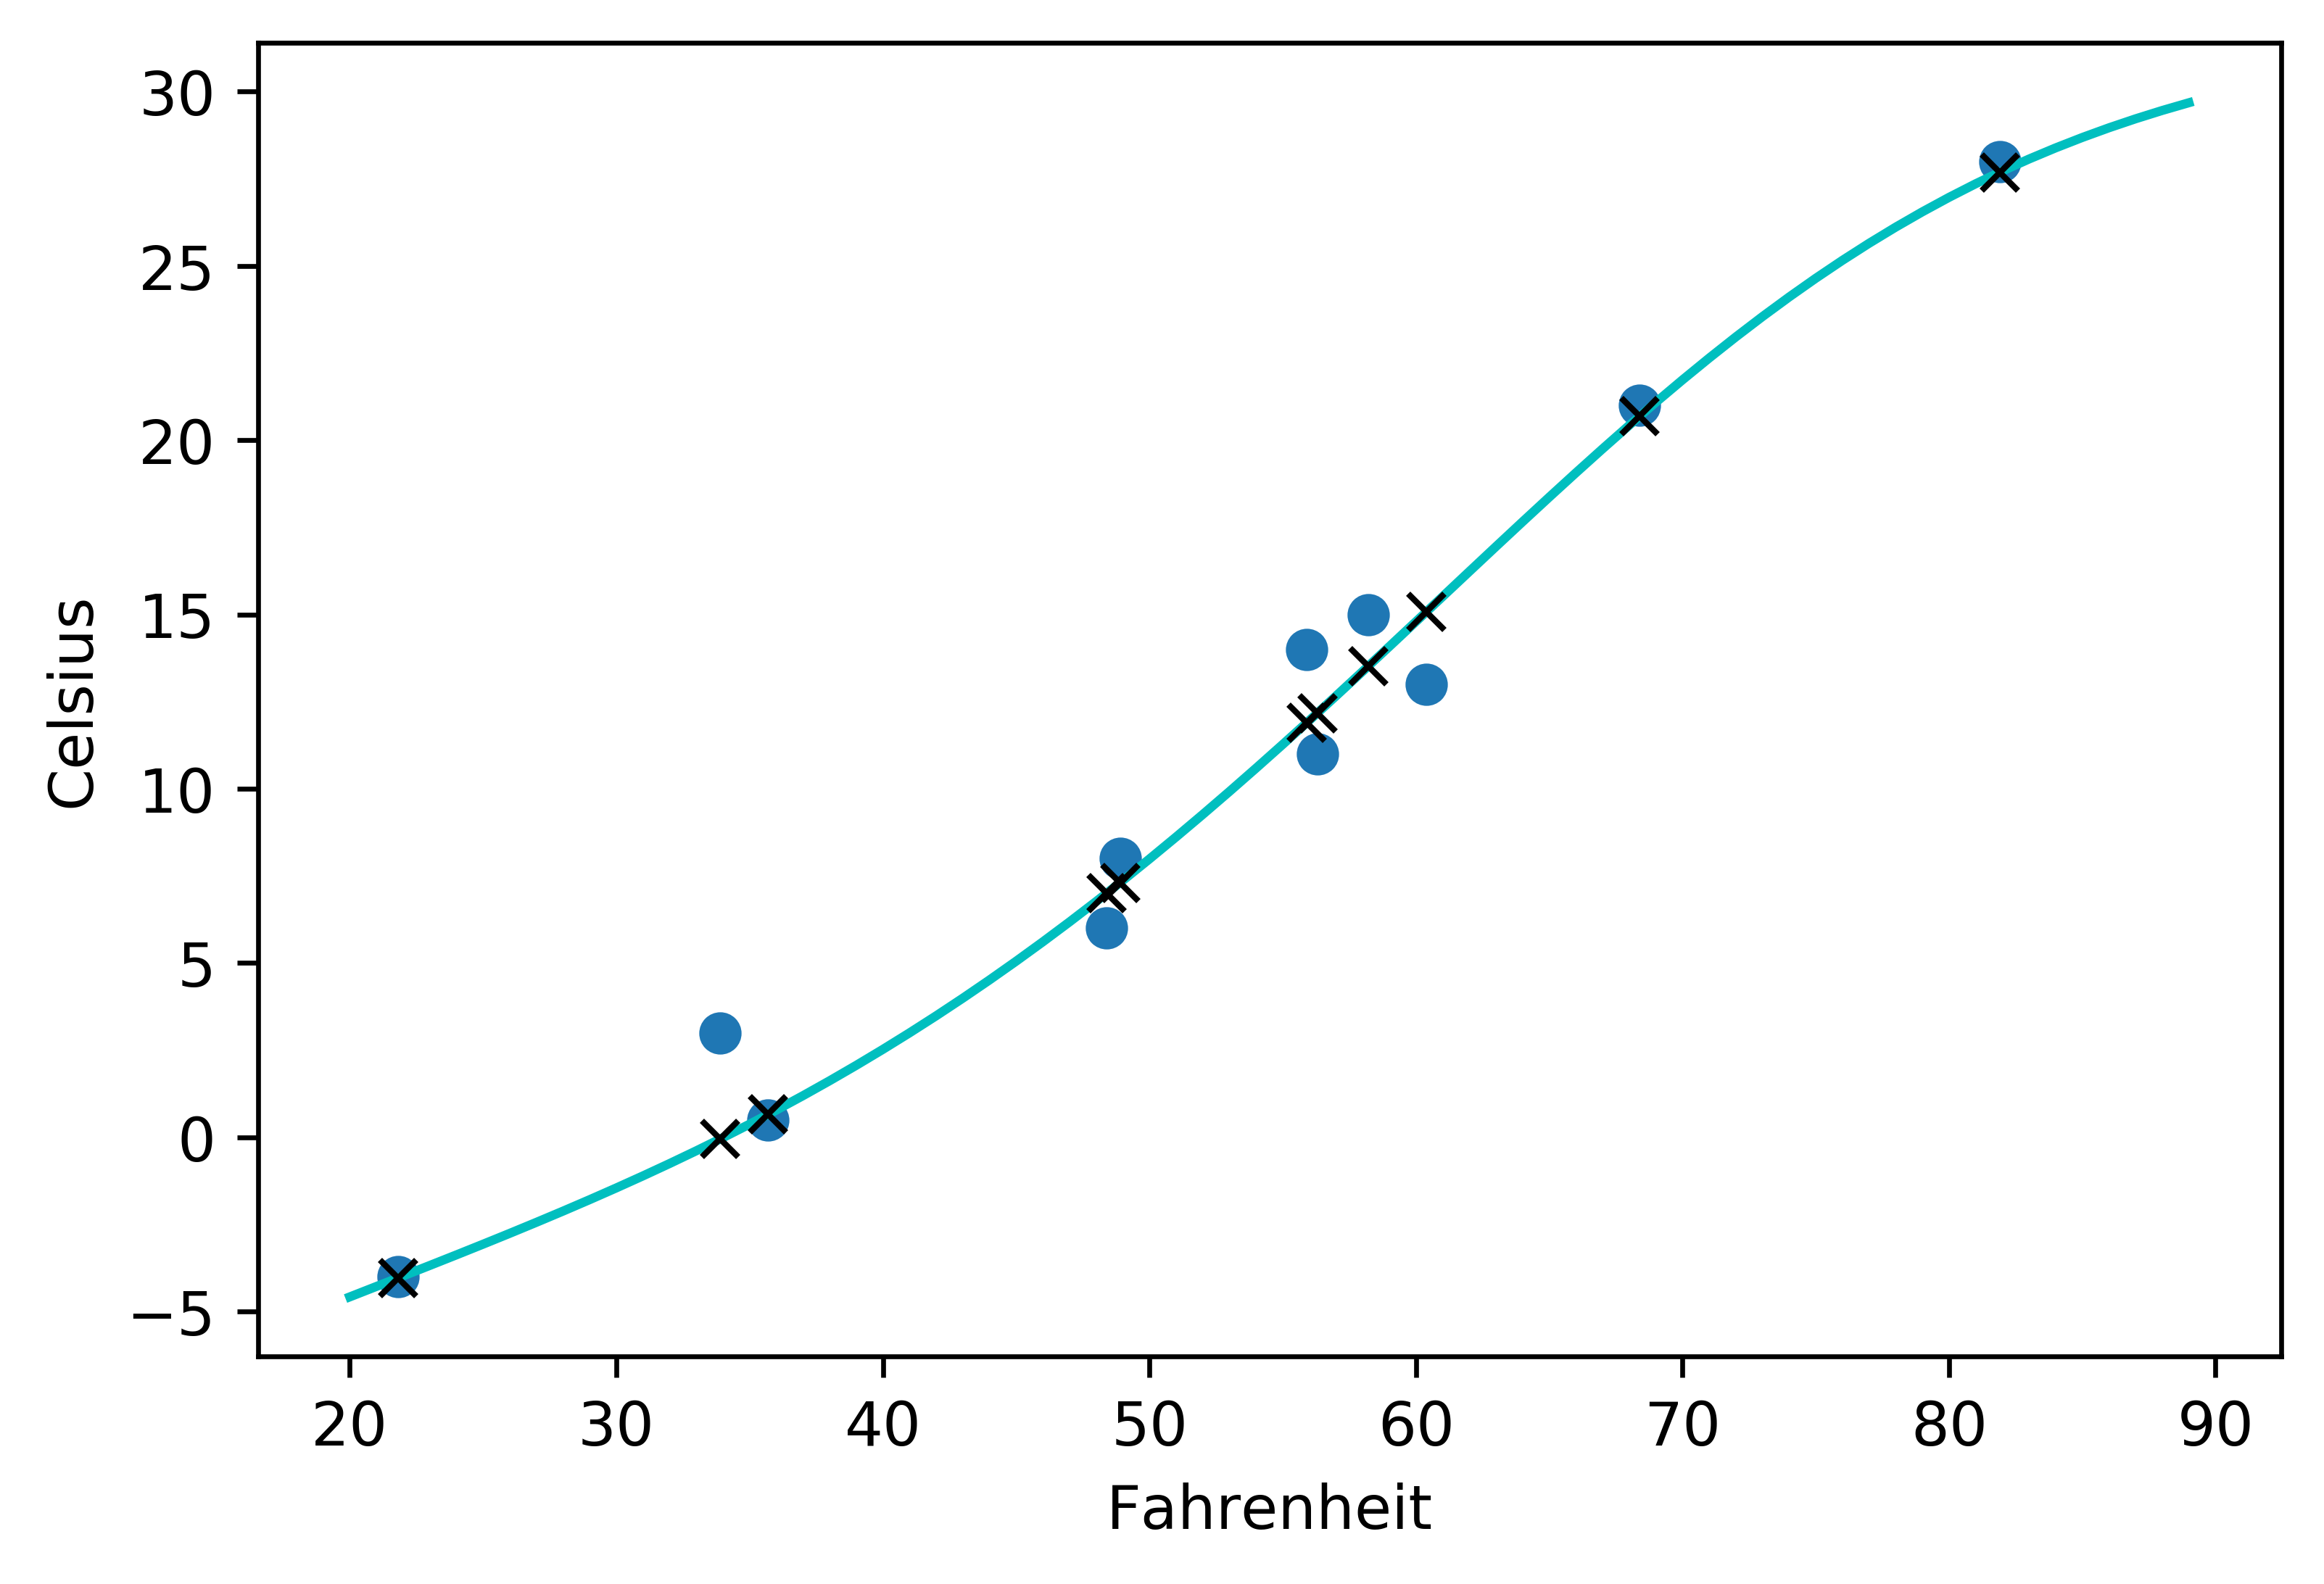

In [49]:
from matplotlib import pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')